# Практика: Изображения как данные + базовый препроцессинг (OpenCV)
Эта практика повторяет ключевые идеи лекции:
- изображение как массив чисел (shape / dtype / range)
- BGR vs RGB
- resize/crop/pad и сохранение пропорций (letterbox)
- нормализация под нейросети
- sanity-checks пайплайна

Можно запускать последовательно. Никаких баллов — это «песочница».

## 0) Импорты и генерация тестовых изображений
Чтобы не тянуть данные из интернета, создадим несколько синтетических картинок прямо в рантайме.

In [2]:
import os
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

def show(img_rgb, title=None):
    plt.figure(figsize=(4,4))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.show()

# 1) Цветовые блоки (проверка каналов)
h, w = 120, 180
img = np.zeros((h, w, 3), dtype=np.uint8)
# Левый блок красный (в BGR это (0,0,255))
img[:, :60]  = (0, 0, 255)
# Средний блок зелёный (0,255,0)
img[:, 60:120] = (0, 255, 0)
# Правый блок синий (255,0,0)
img[:, 120:] = (255, 0, 0)
cv2.imwrite(str(DATA_DIR / 'color_blocks.png'), img)

# 2) Градиент (для resize)
h2, w2 = 80, 240
x = np.linspace(0, 255, w2, dtype=np.uint8)
grad = np.tile(x, (h2, 1))
grad_img = np.stack([grad, np.flipud(grad), grad], axis=-1)  # BGR
cv2.imwrite(str(DATA_DIR / 'gradient.png'), grad_img)

# 3) Текст (для OCR/резкости)
txt = np.full((140, 320, 3), 255, dtype=np.uint8)
cv2.putText(txt, 'OpenCV', (20, 90), cv2.FONT_HERSHEY_SIMPLEX, 2.2, (0,0,0), 4, cv2.LINE_AA)
cv2.imwrite(str(DATA_DIR / 'text.png'), txt)

print('Generated:', [p.name for p in DATA_DIR.iterdir()])

Generated: ['.ipynb_checkpoints', 'color_blocks.png', 'gradient.png', 'text.png']


## 1) BGR vs RGB
OpenCV читает изображение в BGR. Для matplotlib обычно нужен RGB.

BGR shape: (120, 180, 3) dtype: uint8
Pixel left block (BGR): [0, 0, 255]
Pixel left block (RGB): [255, 0, 0]


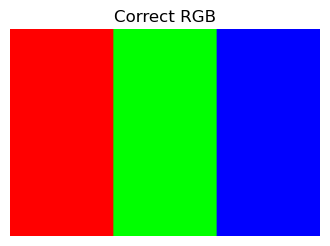

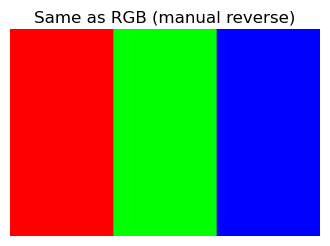

In [3]:
bgr = cv2.imread(str(DATA_DIR / 'color_blocks.png'))
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
print('BGR shape:', bgr.shape, 'dtype:', bgr.dtype)
print('Pixel left block (BGR):', bgr[0, 10].tolist())
print('Pixel left block (RGB):', rgb[0, 10].tolist())
show(rgb, 'Correct RGB')
# Для контраста — покажем как будет выглядеть, если забыть конвертацию:
show(bgr[..., ::-1], 'Same as RGB (manual reverse)')

## 2) dtype и диапазоны
Частая схема для нейросетей: uint8 (0..255) → float32 (0..1) → (x-mean)/std

In [4]:
img_rgb = cv2.cvtColor(cv2.imread(str(DATA_DIR / 'gradient.png')), cv2.COLOR_BGR2RGB)
print('uint8:', img_rgb.dtype, img_rgb.min(), img_rgb.max())
img_f = img_rgb.astype(np.float32) / 255.0
print('float32:', img_f.dtype, float(img_f.min()), float(img_f.max()))

uint8: uint8 0 255
float32: float32 0.0 1.0


## 3) Resize: ломаем пропорции или сохраняем?
Сравним обычный resize и letterbox (resize + pad).

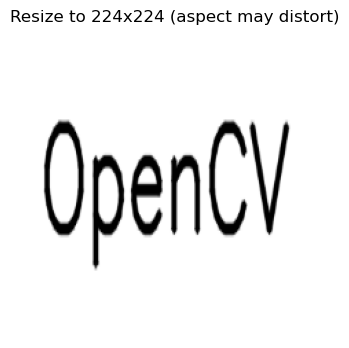

Letterbox info: {'scale': 0.7, 'top': 63, 'left': 0, 'new_hw': (98, 224)}


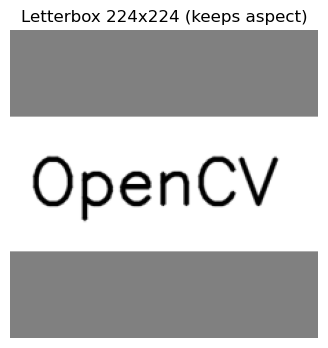

In [5]:
src = cv2.cvtColor(cv2.imread(str(DATA_DIR / 'text.png')), cv2.COLOR_BGR2RGB)
H, W = src.shape[:2]
target = (224, 224)

# 3.1 Обычный resize (пропорции ломаются)
resized = cv2.resize(src, target[::-1], interpolation=cv2.INTER_LINEAR)
show(resized, 'Resize to 224x224 (aspect may distort)')

# 3.2 Letterbox: сохраняем аспект + pad
def letterbox(img_rgb, target_hw=(224,224), pad_value=0):
    th, tw = target_hw
    h, w = img_rgb.shape[:2]
    scale = min(tw / w, th / h)
    nw, nh = int(round(w * scale)), int(round(h * scale))
    resized = cv2.resize(img_rgb, (nw, nh), interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_LINEAR)
    out = np.full((th, tw, 3), pad_value, dtype=img_rgb.dtype)
    top = (th - nh) // 2
    left = (tw - nw) // 2
    out[top:top+nh, left:left+nw] = resized
    return out, {'scale': scale, 'top': top, 'left': left, 'new_hw': (nh, nw)}

lb, info = letterbox(src, target_hw=target, pad_value=128)
print('Letterbox info:', info)
show(lb, 'Letterbox 224x224 (keeps aspect)')

## 4) Цветовые пространства
HSV иногда удобнее для порогов/стабильности к освещению.

HSV sample pixels: [0, 255, 255] [60, 255, 255] [120, 255, 255]


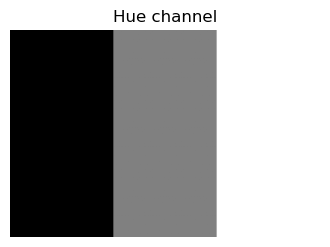

In [6]:
rgb = cv2.cvtColor(cv2.imread(str(DATA_DIR / 'color_blocks.png')), cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
print('HSV sample pixels:', hsv[0,10].tolist(), hsv[0,80].tolist(), hsv[0,150].tolist())
# Покажем канал Hue как изображение
plt.figure(figsize=(4,3)); plt.title('Hue channel'); plt.axis('off'); plt.imshow(hsv[...,0], cmap='gray'); plt.show()

## 5) Шум и фильтры
Фильтры могут помогать, но легко убивают детали (особенно текст и мелкие дефекты).

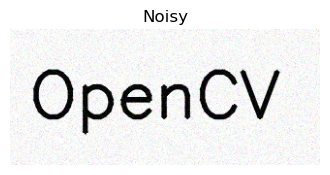

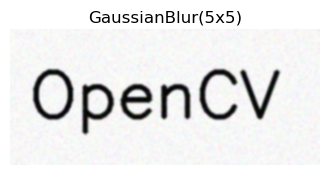

In [8]:
SEED=42
src = cv2.cvtColor(cv2.imread(str(DATA_DIR / 'text.png')), cv2.COLOR_BGR2RGB)
rng = np.random.default_rng(SEED)
noise = rng.normal(0, 18, size=src.shape).astype(np.float32)
noisy = np.clip(src.astype(np.float32) + noise, 0, 255).astype(np.uint8)
blur = cv2.GaussianBlur(noisy, (5,5), 0)
show(noisy, 'Noisy')
show(blur, 'GaussianBlur(5x5)')

## 6) Нормализация под нейросети
Покажем стандартные ImageNet mean/std и проверим статистики после нормализации.

In [9]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

img = cv2.cvtColor(cv2.imread(str(DATA_DIR / 'text.png')), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)
x = img.astype(np.float32)/255.0
x = (x - IMAGENET_MEAN) / IMAGENET_STD
print('normalized: mean ~', x.mean(axis=(0,1)), 'std ~', x.std(axis=(0,1)))

normalized: mean ~ [1.9040604 2.0760543 2.2888887] std ~ [1.1057305 1.1308919 1.1260295]


## 7) Мини-пайплайн preprocess(img, mode)
Идея: train — случайность, eval — детерминированность.

In [10]:
def preprocess_eval(img_bgr, target_hw=(224,224)):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb, _ = letterbox(img_rgb, target_hw=target_hw, pad_value=114)
    x = img_rgb.astype(np.float32)/255.0
    x = (x - IMAGENET_MEAN) / IMAGENET_STD
    x = np.transpose(x, (2,0,1))  # CHW
    return x

bgr = cv2.imread(str(DATA_DIR/'text.png'))
x = preprocess_eval(bgr)
print('tensor shape:', x.shape, 'dtype:', x.dtype, 'min/max:', float(x.min()), float(x.max()))

tensor shape: (3, 224, 224) dtype: float32 min/max: -2.1179039478302 2.640000104904175


## 8) Sanity checks
Перед обучением всегда делайте проверки shape/dtype/range + смотрите примеры «до/после».

In [11]:
def sanity_report(arr):
    a = np.array(arr)
    return {
        'shape': tuple(a.shape),
        'dtype': str(a.dtype),
        'min': float(np.min(a)),
        'max': float(np.max(a)),
        'mean': float(np.mean(a)),
        'std': float(np.std(a)),
        'has_nan': bool(np.isnan(a).any()) if np.issubdtype(a.dtype, np.floating) else False,
    }

print(sanity_report(x))

{'shape': (3, 224, 224), 'dtype': 'float32', 'min': -2.1179039478302, 'max': 2.640000104904175, 'mean': 0.9096402525901794, 'std': 1.2825562953948975, 'has_nan': False}
